In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [25]:
# TRAINED IN UTC TIME (MODEL MUST US UTC)
df = pd.read_csv('./data/UCY_SM_historical_with_weather.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

In [26]:
# Drop columns of SM not in use / messed up
drop_sm = ['Pac_Total-Meter-1', 'Pac_Total-Meter-2', 'Pac_Total-Meter-5', 'time']
for i in range(20, 27):
    drop_sm.append(f'Pac_Total-Meter-{i}')

df = df.drop(columns=drop_sm)
df = df.dropna()

In [30]:
# Get rid of outliers
df_clean = df.copy()
def remove_outliers(df, column):
    # Q1 = df[column].quantile(0.25)
    # Q3 = df[column].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 100000 * IQR

    return df[df[column] < 100000000]

df_clean = remove_outliers(df_clean, 'Total_Pac_MW')
for i in range(3, 17):
    if i != 9 and i != 5:
        df_clean = remove_outliers(df_clean, f'Pac_Total-Meter-{i}')

df.shape[0] - df_clean.shape[0]

79

In [31]:
import random

from pyparsing import col

columns = [
    "Pac_Total-Meter-3",
    "Pac_Total-Meter-4",
    "Pac_Total-Meter-6",
    "Pac_Total-Meter-7",
    "Pac_Total-Meter-8",
    "Pac_Total-Meter-10",
    "Pac_Total-Meter-11",
    "Pac_Total-Meter-12",
    "Pac_Total-Meter-13",
    "Pac_Total-Meter-14",
    "Pac_Total-Meter-15",
    "Pac_Total-Meter-16",
    "Tamb-temp",
    "Total_Pac_MW",
    "humidity",
    "precipMM",
    "GHI-GhPyr",
]
df_summer = df_clean[df_clean.datetime > pd.Timestamp("2024-06-03")]
df_new_summer = pd.DataFrame()
for i in range(0, 7):
    new_week = pd.DataFrame()
    num = random.randint(0, 3)
    first_week = df_summer[
        (df_summer.datetime > (pd.Timestamp("2024-06-03 00:00:00") + pd.Timedelta(weeks=num)))
        & (df_summer.datetime
        < (pd.Timestamp("2024-06-03") + pd.Timedelta(weeks=num + 1)))
    ]
    num2 = random.randint(0, 3)
    second_week = df_summer[
        (df_summer.datetime > (pd.Timestamp("2024-06-03") + pd.Timedelta(weeks=num2)))
        & (df_summer.datetime
        < (pd.Timestamp("2024-06-03") + pd.Timedelta(weeks=num2 + 1)))
    ]
    for column in df_summer.columns:
        if column == 'datetime':
            new_week['datetime'] = first_week['datetime'] + pd.Timedelta(weeks=i + 5 - num)
        else:
            new_week[column] = first_week[column]
    if i == 0:
        df_new_summer = new_week
    else:
        df_new_summer = pd.concat([df_new_summer, new_week], axis=0)
print(df_new_summer.shape)
df_new_summer.head(100)
df_new_summer.sort_values(by='datetime')
df_clean = pd.concat([df_clean, df_new_summer], axis=0)


(4676, 18)


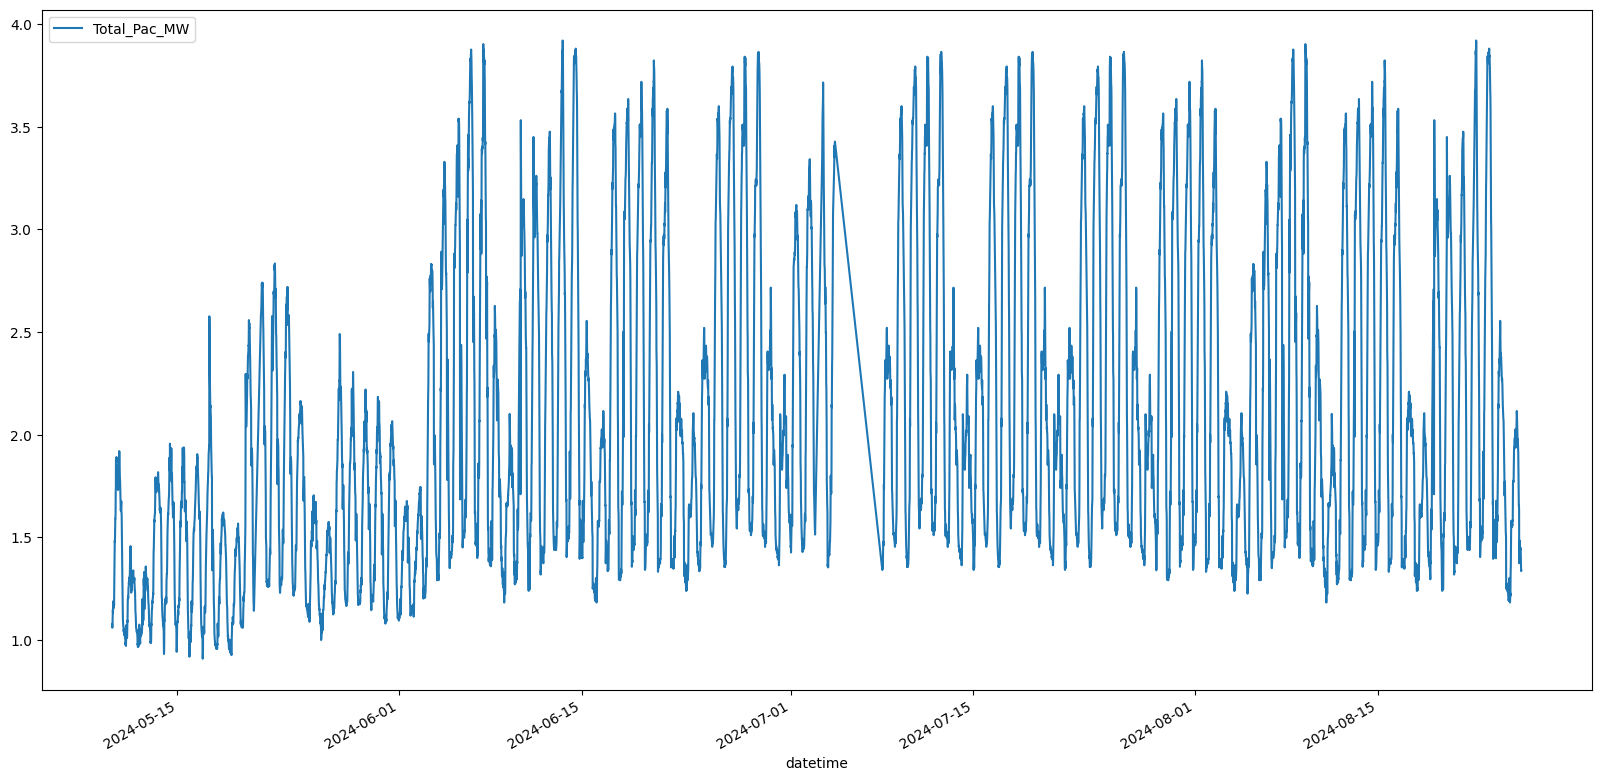

In [32]:
_ = df_clean[df_clean.datetime > pd.Timestamp('2024-05-10')].plot(x='datetime', y='Total_Pac_MW', figsize=(20, 10))

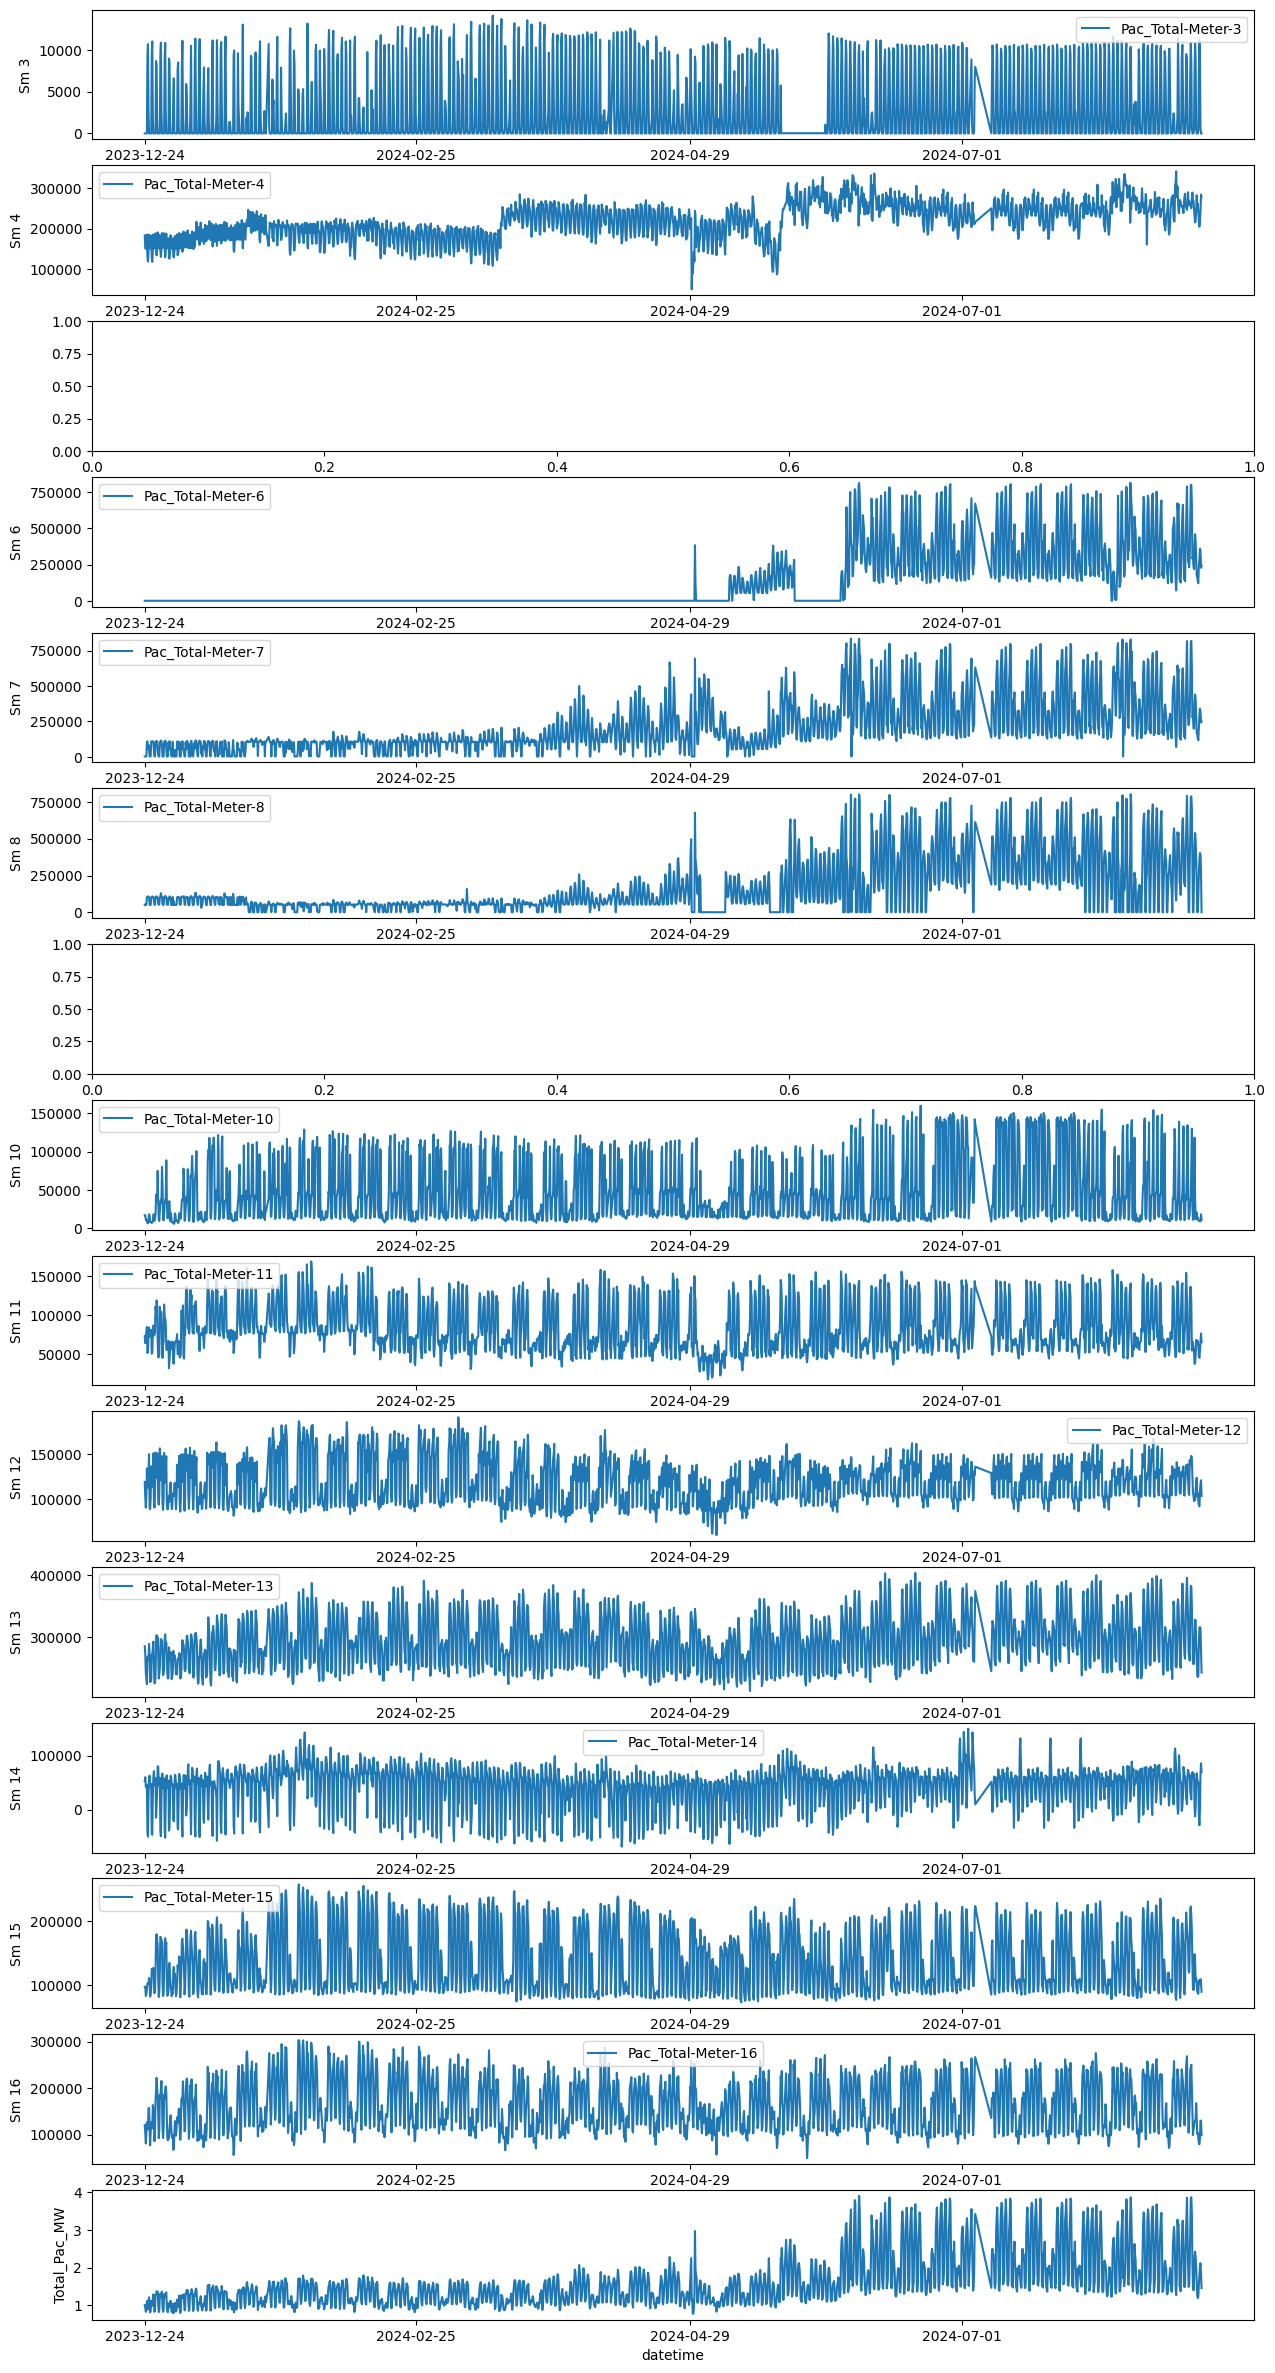

In [33]:
# Create subplots
df_for_plot = df_clean[5000:]
df_for_plot = df_for_plot.iloc[::12]
fig, axs = plt.subplots(15, 1, figsize=(15, 30))

# Plot 'Total_Pac_MW' and 'Pac_Total-Meter-{i}' columns for all i from 3 to 16
for i in range(3, 17):
    if not i == 9 and not i == 5:
        axs[i-3].plot(df_for_plot['datetime'], df_for_plot[f'Pac_Total-Meter-{i}'], label=f'Pac_Total-Meter-{i}')
        axs[i-3].set_xlabel('datetime')
        axs[i-3].set_xticks(df_for_plot['datetime'][::500])
        axs[i-3].set_ylabel(f'Sm {i}')
        axs[i-3].legend()

axs[14].plot(df_for_plot['datetime'], df_for_plot['Total_Pac_MW'], label='Total_Pac_MW')
axs[14].set_xlabel('datetime')
axs[14].set_xticks(df_for_plot['datetime'][::500])
axs[14].set_ylabel('Total_Pac_MW')

# Show the plot
plt.show()

In [34]:
# Create features 
def create_features(_df):
    df = _df.copy()
    df['minute'] = df['datetime'].dt.minute + df['datetime'].dt.hour * 60
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month

    # df['lag_1'] = df['Total_Pac_MW'].shift(96)
    # df['lag_2'] = df['Total_Pac_MW'].shift(192)
    # df['lag_3'] = df['Total_Pac_MW'].shift(288)
    df = df.dropna()
    
    return df[['minute', 'day_of_week', 'day_of_year', 'month', 'Tamb-temp', 'humidity', 'precipMM', 'GHI-GhPyr']], df['Total_Pac_MW']

In [48]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*4*7)

[0]	validation_0-rmse:0.47582	validation_1-rmse:0.72741
[100]	validation_0-rmse:0.10434	validation_1-rmse:0.24825
[200]	validation_0-rmse:0.08717	validation_1-rmse:0.21986
[300]	validation_0-rmse:0.07790	validation_1-rmse:0.21156
[400]	validation_0-rmse:0.07181	validation_1-rmse:0.20018
[412]	validation_0-rmse:0.07124	validation_1-rmse:0.19986
[0]	validation_0-rmse:0.48598	validation_1-rmse:0.84672
[100]	validation_0-rmse:0.10545	validation_1-rmse:0.28672
[200]	validation_0-rmse:0.08857	validation_1-rmse:0.25189
[300]	validation_0-rmse:0.07927	validation_1-rmse:0.24183
[400]	validation_0-rmse:0.07303	validation_1-rmse:0.23478
[500]	validation_0-rmse:0.06864	validation_1-rmse:0.22863
[574]	validation_0-rmse:0.06614	validation_1-rmse:0.23007
[0]	validation_0-rmse:0.49625	validation_1-rmse:0.74089
[100]	validation_0-rmse:0.10621	validation_1-rmse:0.16388
[200]	validation_0-rmse:0.09072	validation_1-rmse:0.15254
[300]	validation_0-rmse:0.08114	validation_1-rmse:0.14537
[400]	validation_0-r

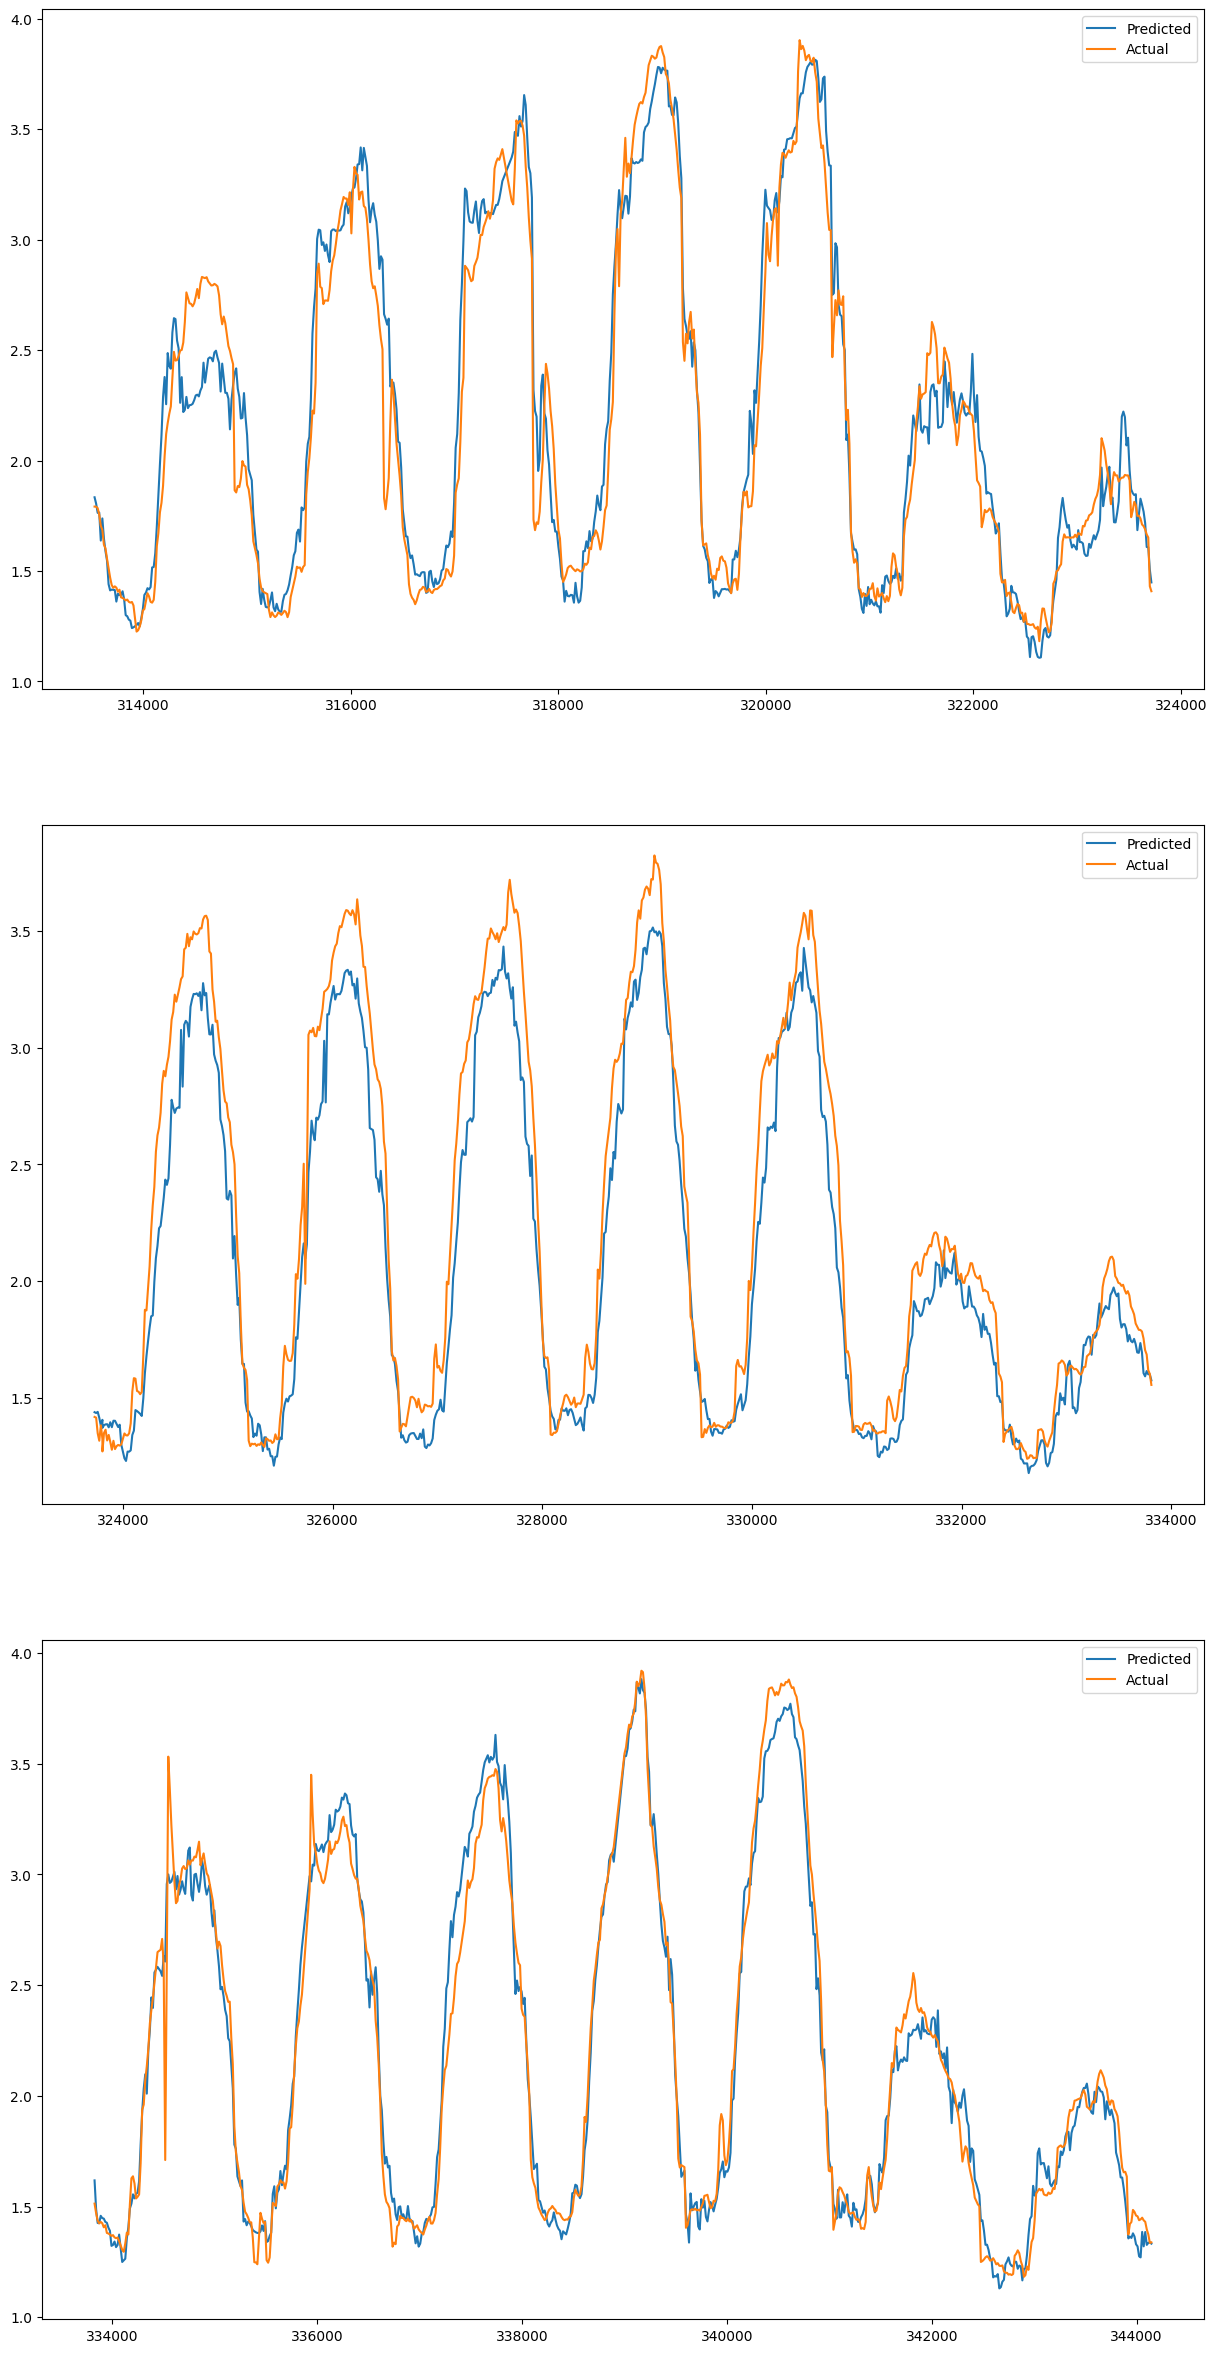

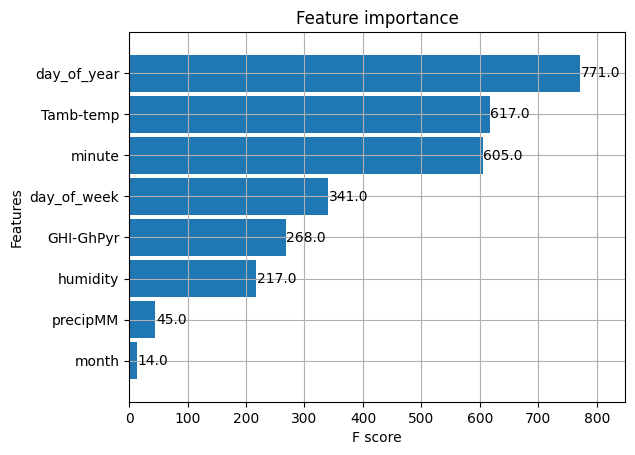

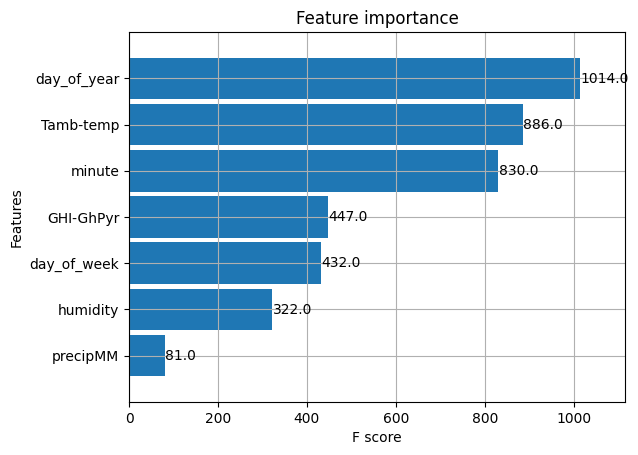

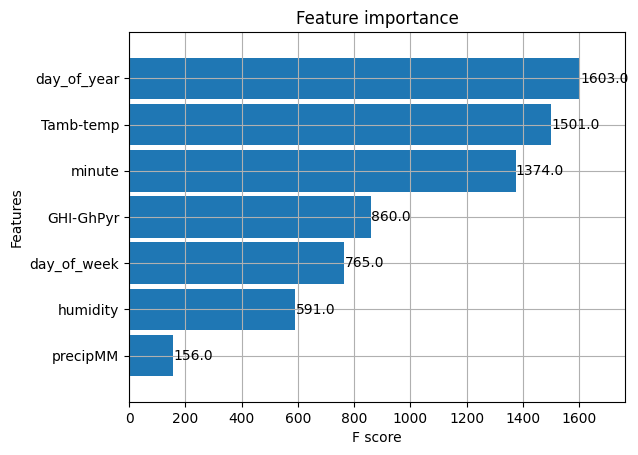

In [49]:
# Time series cross validation testing

from sklearn.metrics import mean_squared_error
from xgboost import plot_importance


fold = 0
preds = []
scores = []
pred_indxs = []
regs = []
# tuned_preds = []
fig, axs = plt.subplots(3, 1, figsize=(15, 30))
i = 0

for train_idx, test_idx in tss.split(df_clean):
    df_train = df_clean.iloc[train_idx]
    df_test = df_clean.iloc[test_idx]
    pred_indxs.append(test_idx)

    X_train, y_train = create_features(df_train)
    X_test, y_test = create_features(df_test)

    reg = xgb.XGBRegressor(n_estimators=3000, objective='reg:squarederror', n_jobs=-1, max_depth=3)
    reg.set_params(
    eval_metric='rmse',
    early_stopping_rounds=50
    )
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    regs.append(reg)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    X_test['graph_min'] = (X_test['minute'] + ((X_test['day_of_year']) * 24 * 60))
    axs[i].plot(X_test['graph_min'], y_pred, label='Predicted')
    axs[i].plot(X_test['graph_min'], y_test, label='Actual')
    axs[i].legend()
    _ = plot_importance(reg, height=0.9)

    i += 1


print(f'Average RMSE: {np.mean(scores)}')
print(f'Individual RMSE Scores: {scores}')
plt.show()

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
all_features, all_correct = create_features(df_clean)
avg_MAPE = 0
for reg in regs:
    all_predictions = reg.predict(all_features)
    avg_MAPE += mean_absolute_percentage_error(all_correct, all_predictions)

avg_MAPE /= len(regs)
print(f'Average MAPE: {avg_MAPE}')


Average MAPE: 3.6074500150556545


In [52]:
# save each regressor to its own file
for i, reg in enumerate(regs):
    reg.save_model(f'xgboost_load_model_{i}.bin')

/Users/alextseng/Documents/ucy-pv-forecasting/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:14:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
